The assumption is that each sensory neuron is Poisson and depends on a variable $z \in R^K$, and the population firing $s = \{ s_1,...,s_N \} \sim P(s|z) = \prod_i P(s_i | z)$, where

$$P(s_i | z) = \frac{ \lambda_i(z)^{s_i}e^{- \lambda_i(z)}}{s_i!}$$

We want to sample from the posterior $P(z | s) \propto P(s|z) \propto e^{-U(z)} = e^{-\sum_i U_i(z)}$.

In [2]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# No network yet - Simulate the equations

In [3]:
# Simulation parameters
Time = T = 10 # total time
dt = 0.001 # time step
nT = Nt = int(Time/dt) # number of time steps

In [4]:
np.random.seed(2)
# signal & (input) neuron dimension
K=3 # dimension Z
N=100 # number of sensory neurons

r0 = 10 # base firing rate
A=np.random.randn(N,K) # affinity matrix

# consider signals with different freqs and magnitudes
zo = np.arange(1,K+1)/5 * np.array([np.cos(np.linspace(b,10 + b,nT)*b) + 1 for b in np.random.rand(K)*np.pi]).T

# get Poisson samples according to r_0 + Az
s = np.random.poisson(r0 + zo@A.T, [nT,N])

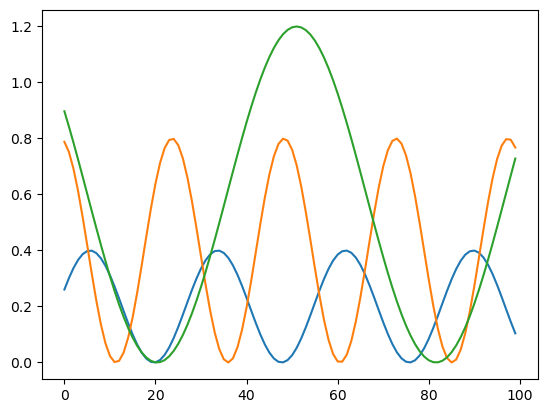

In [5]:
plt.plot(zo[::100])

Almost naive Langevin:
$d\mathbf{z}(t) = - \epsilon \nabla U(\mathbf{z})\, dt + \sqrt{2 \epsilon}\, d\mathbf{W}(t)$

 We need 
$\nabla_z U(z) = \sum_i (\nabla_z \lambda_i(z)) \left(1-\frac{s_i}{\lambda_i(z)} \right) $

In the case where $\lambda_i(z) = r_0 + \alpha_i \cdot z$, $\alpha_i \in R^K$,

$\nabla_z U(z) = \sum_i \alpha_i \left(1-\frac{s_i}{r_0 + \alpha_i \cdot z} \right) $

Let's call $A$ the matrix formed by all $\alpha_i$s. Then 

$\nabla_z U(z) = \sum_i \alpha_i \left(1-\frac{s_i}{r_0 + \alpha_i \cdot z} \right) = -A^T \left(\frac{s}{r_0 + Az} -1 \right)$, where $\frac{s}{r_0 + Az}$ is an element-wise division among N-dim vectors.

In [6]:
def DU(z,s,A=A):
    return A.T@(1 - s/(r0 + A@z))

In [7]:
eps=10
z = np.zeros([nT,K])
z[0] = zo[0]
for t in range(1,nT):
    z[t] = z[t-1] - dt*eps*DU(z[t-1],s[t-1]) + np.sqrt(2*dt*eps)*np.random.randn(K)

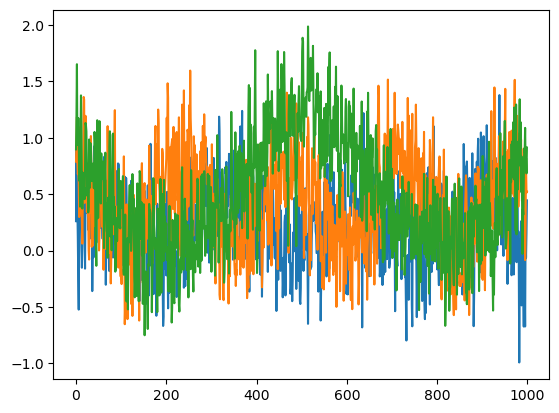

In [8]:
plt.plot(z[::10])

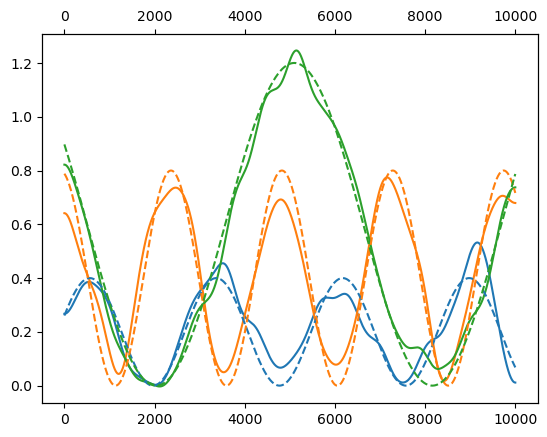

In [9]:
# smooth to get a running average
plt.plot(ndimage.gaussian_filter1d(z,200,axis=0))
plt.twiny()
plt.plot(zo,ls='--') # true signal

# Implement a n-th order truncation of 1/(1+x)

In [10]:
# gradient with an n-th order approx of s/(r0+Az)
def DUn(z,s=np.ones(N),A=A,n=10):
    # want to approximate s/(r0 + A@z)
    sr0az = s/r0*np.sum([(-A@z/r0)**k for k in range(n+1)],0)
    return A.T@(1 - sr0az)

### third order approx

In [11]:
eps=10
z = np.zeros([nT,K])
z[0] = zo[0]
for t in range(1,nT):
    z[t] = z[t-1] - dt*eps*DUn(z[t-1],s[t-1],n=3) + np.sqrt(2*dt*eps)*np.random.randn(K)

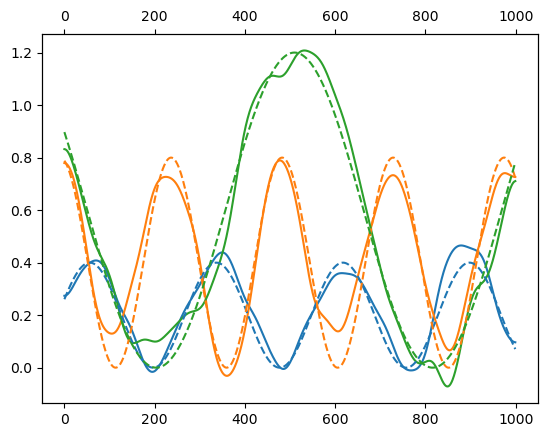

In [12]:
plt.plot(ndimage.gaussian_filter1d(z,200,axis=0)[::10])
plt.twiny()
plt.plot(zo[::10],ls='--')

### second order approx

In [13]:
eps=10
z = np.zeros([nT,K])
z[0] = zo[0]
for t in range(1,nT):
    z[t] = z[t-1] - dt*eps*DUn(z[t-1],s[t-1],n=1) + np.sqrt(2*dt*eps)*np.random.randn(K)

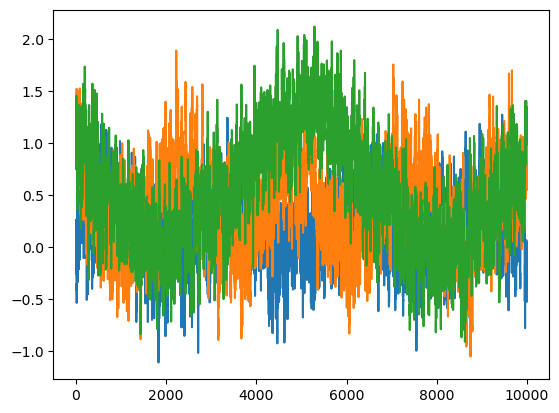

In [14]:
plt.plot(z)

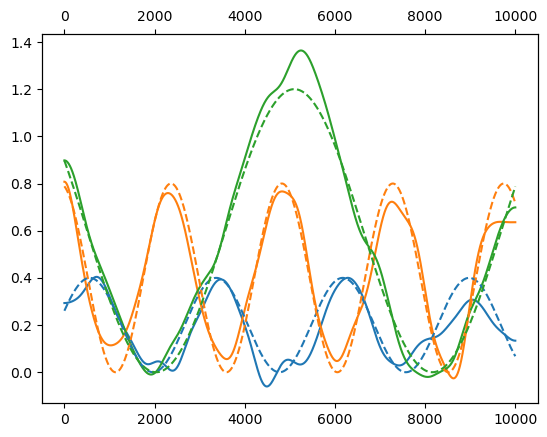

In [15]:
plt.plot(ndimage.gaussian_filter1d(z,200,axis=0))
plt.twiny()
plt.plot(zo,ls='--')

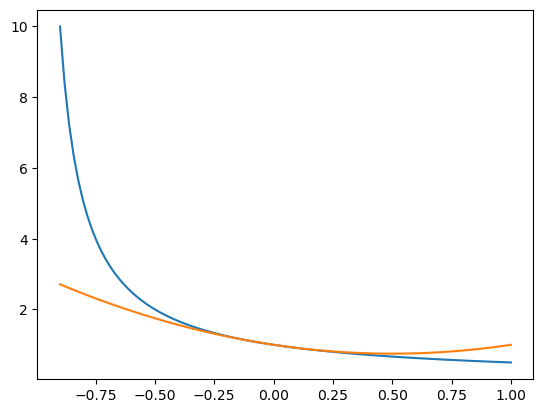

In [16]:
### 2nd order approx is not too bad!! ###
# reason: a second order approx of 1/(1+x) is good close to zero, and ok-ish if we are within (-1, 1)
x = np.linspace(-0.9, 1, 100)
plt.plot(x, 1 / (1+x))
plt.plot(x,1 - x + x**2)# - x**3)# + x**4)

# SCN with nonlinear synapses

**Notation:**

Network spikes $\sigma$

Filtered spikes $\dot r = -\lambda r + \sigma$

Readout $\hat z = D r$

**Network dynamics**
$$\frac{dv}{dt} = -\lambda v + \epsilon D^T A^T (1-\frac{s}{r_0 + A D r}) + \sqrt{2\epsilon} D^T dW(t) + \lambda D^TD r - D^TD\sigma$$

Breakdown:

Fast synapses: $-D^T D$

Slow (linear) synapses: $\lambda D^TD$

Nonlinear computation on $r$: $\epsilon D^T A^T (1-\frac{s}{r_0 + A D r})$ (not realistic for now - needs to be approx either with nonlinear syanpses or another net)

"Noise correlations": $\sqrt{2\epsilon} D^T dW(t)$ low-D gaussian noise projected to voltages through $D^T$

In [17]:
# Network parameters
Nn = 200 # Number of neurons
# K = 3 # dimensionality of z (SET ABOVE)

# decoding matrix: bunch of normalized and re-size random vectors
np.random.seed(42) # for reproducibility
D=np.random.randn(K,Nn) 
D = D / np.sqrt(np.diag(D.T@D)) # normalize vectors

# voltage decay constant
lam=5

# thresholds
T = np.diag(D.T@D)/2

In [18]:
V = np.zeros([Nn,Nt+1])
sigma = np.zeros([Nn,Nt+1])
r = np.zeros([Nn,Nt+1])

# Set initial conditions
r[:,0] = np.array(np.linalg.pinv(D)@zo[0]) # set initial condition through pseudo-inverse
V[:,0] = 0.95*T # fairly close to firing thr

In [19]:
### network connections ###
# - fast
O_f = - D.T @ D
# - slow
O_s = lam * D.T @ D
# - nonlinear part (not biological plausible atm)
epsilon=10
def O_nl(r,s): # need the 
    return  epsilon * D.T @ A.T @(1 - s / (r0 + A@D@r))

In [20]:
# simple forward Euler
for t in range(Nt):
    V[:,t+1] = V[:,t] + dt*(-lam*V[:,t] + O_f@sigma[:,t] + O_s @ r[:,t] - O_nl(r[:,t],s[t]) + np.sqrt(epsilon*2)*D.T@np.random.randn(K))
    
    # check if there are neurons whose voltage is above threshold
    above = np.where(V[:,t+1] > T)[0]
    
    # introduce a control to let only one neuron fire
    if len(above):
        sigma[np.argmax(V[:,t+1]),t+1] = 1/dt
    
    # update rate
    r[:,t+1] = r[:,t] + dt*(sigma[:,t+1] - lam*r[:,t])

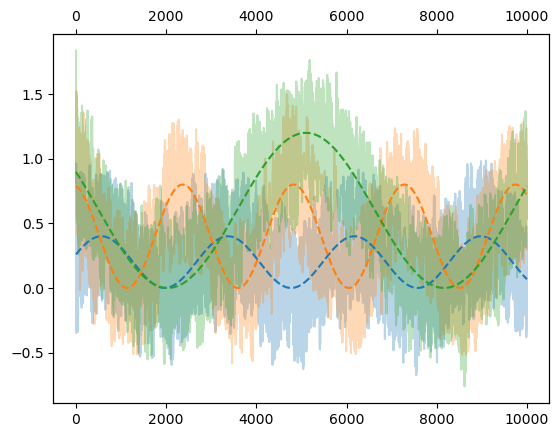

In [21]:
plt.plot((D@r).T,alpha=0.3,label='output')
plt.twiny()
plt.plot(zo,ls='--',label='true')

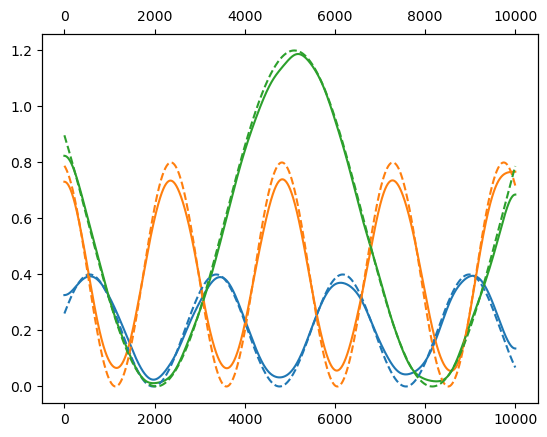

In [22]:
# smoothed output - nice!
plt.plot(ndimage.gaussian_filter1d((D@r).T,200,axis=0))
plt.twiny()
plt.plot(zo,ls='--',label='true')

# SCN with pirwise multiplicative synapses

So we said
$$\nabla U(z) = \sum_i \nabla U_i(z) = \sum_i \alpha_i \left[ 1 - \frac{s_i}{r_0} \left( \frac{1}{1 + \frac{\alpha_i \cdot z}{r_0}} \right) \right]$$
Let's approx $\frac{1}{1 + x} \approx 1 - x + x^2$, so
$$\nabla U(z) = \sum_i \alpha_i \left[ 1 - \frac{s_i}{r_0} \left( 1 - \frac{\alpha_i \cdot z}{r_0} + \frac{(\alpha_i \cdot z)^2}{r_0^2} \right) \right] $$
If we use $z = Dr$, then we can rewrite $(\alpha_i \cdot z)^2$ as
$$(\alpha_i \cdot z)^2 = (\alpha_i \cdot Dr)^2 = (\alpha_i \otimes \alpha_i)(Dr \otimes Dr) = (\alpha_i \otimes \alpha_i)(D \otimes D)(r \otimes r)$$
so, the multiplicative part of $\nabla U$ becomes
$$\sum_i \frac{s_i}{r_0} \frac{(\alpha_i \cdot z)^2}{r_0^2} = \sum_i \frac{s_i}{r_0^3} (\alpha_i \otimes \alpha_i)(D \otimes D)(r \otimes r)$$

**Network dynamics**

$$\frac{dv}{dt} = -\lambda v 
+\epsilon D^T \sum_i \alpha_i\left[ 1 - \frac{s_i}{r_0} + \frac{s_i \alpha_i^T D}{r_0^2} r - \frac{s_i (\alpha_i \otimes \alpha_i)(D \otimes D)}{r_0^3}  r^{\otimes 2}\right] 
+ \sqrt{2\epsilon} D^T dW(t) + \lambda D^TD r - D^TD\sigma$$


Breakdown (in order):

Fast synapses: $\Omega_f = -D^T D$

Slow (linear) synapses: $\lambda D^TD + \Omega_i\frac{s}{r_0}AD$

Constant: $\Omega_c = \epsilon D^T A^T \mathbb{1}$, where $\mathbb{1} = [1,1,\dots,1]^T$

Incoming spikes: $\Omega_{is} = \frac{\epsilon}{r_0} D^T \sum_i \alpha_i s_i = \epsilon D^T A^T s$

Slow linear synapses with incoming spikes: $\Omega_{slis} = \frac{\epsilon}{r_0^2} D^T \sum_i s_i \alpha_i \alpha_i^T D r$

Multipl. linear synapses with incoming spikes: $\Omega_{mlis} = \frac{\epsilon}{r_0^3} D^T \sum_i s_i \alpha_i (\alpha_i\otimes\alpha_i)(D \otimes D) r^{\otimes 2}$

"Noise correlations": $\sqrt{2\epsilon} D^T dW(t)$ low-D gaussian noise projected to voltages through $D^T$ - not sure how to make this more biologically plausible.


In [23]:
### network connections & co ###
epsilon=10
# - fast
O_f = - D.T @ D
# - slow (incoming spike independent)
O_s = lam * D.T @ D
# - constant
O_c = epsilon * D.T @ A.T @ np.ones(N)

# - incoming spikes
def O_is(s): return epsilon/r0 * D.T @ A.T @ s
# - slow (interacting with incoming spikes)
AAD = np.array([np.outer(A[i],A[i]) for i in range(N)])@D
# def O_slis(s,r): return epsilon/(r0**2)*D.T@np.einsum('i,ijk->jk',s,AAD@r)
def O_slis(s,r): return epsilon/(r0**2)*D.T@np.einsum('i,ij->j',s,AAD@r)
# - multiplicative synapses (interacting with s)
AAADD = np.array([np.outer(A[i],np.kron(A[i],A[i])) for i in range(N)])@np.kron(D,D)
def O_mlis(s,r): 
    AAADDrr = np.einsum('ijk,k->ij',AAADD,np.kron(r,r))
    return epsilon/(r0**3)*D.T@(s@AAADDrr)

# put all together - 2nd order approx to 1/(1+x)
def O_nl_mult(s,r): #approx to O_nl above
    return O_c - O_is(s) + O_slis(s,r) - O_mlis(s,r)

In [24]:
%%timeit
O_nl_mult(np.random.randn(N),np.random.randn(Nn))

59.5 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
# Network parameters (same as previous net above)
# Nn = 200 # Number of neurons

# # decoding matrix: bunch of normalized and re-size random vectors
# np.random.seed(42) # for reproducibility
# D=np.random.randn(K,Nn) 
# D = D / np.sqrt(np.diag(D.T@D)) # normalize vectors

# # voltage decay constant
# lam=5

# # thresholds
# T = np.diag(D.T@D)/2

In [26]:
V = np.zeros([Nn,Nt+1])
sigma = np.zeros([Nn,Nt+1])
r = np.zeros([Nn,Nt+1])

# Set initial conditions
r[:,0] = np.array(np.linalg.pinv(D)@zo[0]) # pseudo-inverse for initial condition
V[:,0] = 0.95*T # fairly close to firing thr

In [31]:
# simple forward Euler - takes a while - need to improve this
for t in range(Nt):
    V[:,t+1] = V[:,t] + dt*(-lam*V[:,t]
                            +O_f@sigma[:,t] + # fast
                            O_s @ r[:,t] - # slow
                            O_nl_mult(s[t],r[:,t])) + np.sqrt(dt * epsilon * 2)*D.T@np.random.randn(K) # nonlinear part approx with multiplicative synapses + "noise correlations"
    
    # check if there are neurons whose voltage is above threshold
    above = np.where(V[:,t+1] > T)[0]
    
    # let only one neuron fire at each time step
    if len(above):
        sigma[np.argmax(V[:,t+1]),t+1] = 1/dt
    
    # update rate
    r[:,t+1] = r[:,t] + dt*(sigma[:,t+1] - lam*r[:,t])

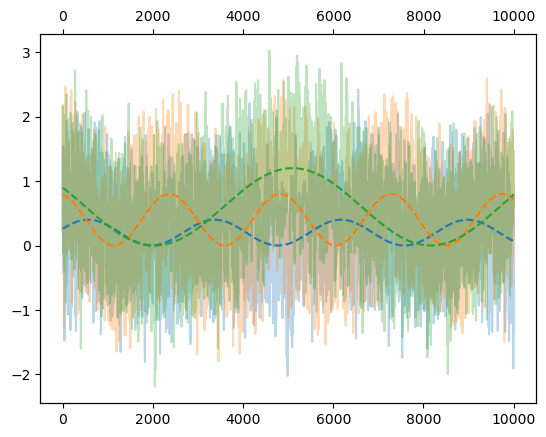

In [32]:
plt.plot((D@r).T,alpha=0.3,label='output')
plt.twiny()
plt.plot(zo,ls='--',label='true')

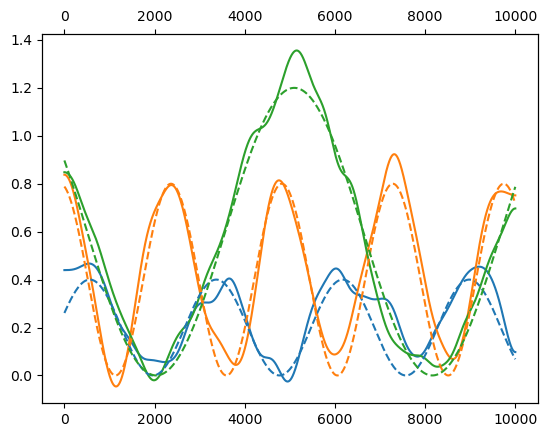

In [33]:
# smoothed output - very good start!
plt.plot(ndimage.gaussian_filter1d((D@r).T,200,axis=0))
plt.twiny()
plt.plot(zo,ls='--',label='true')